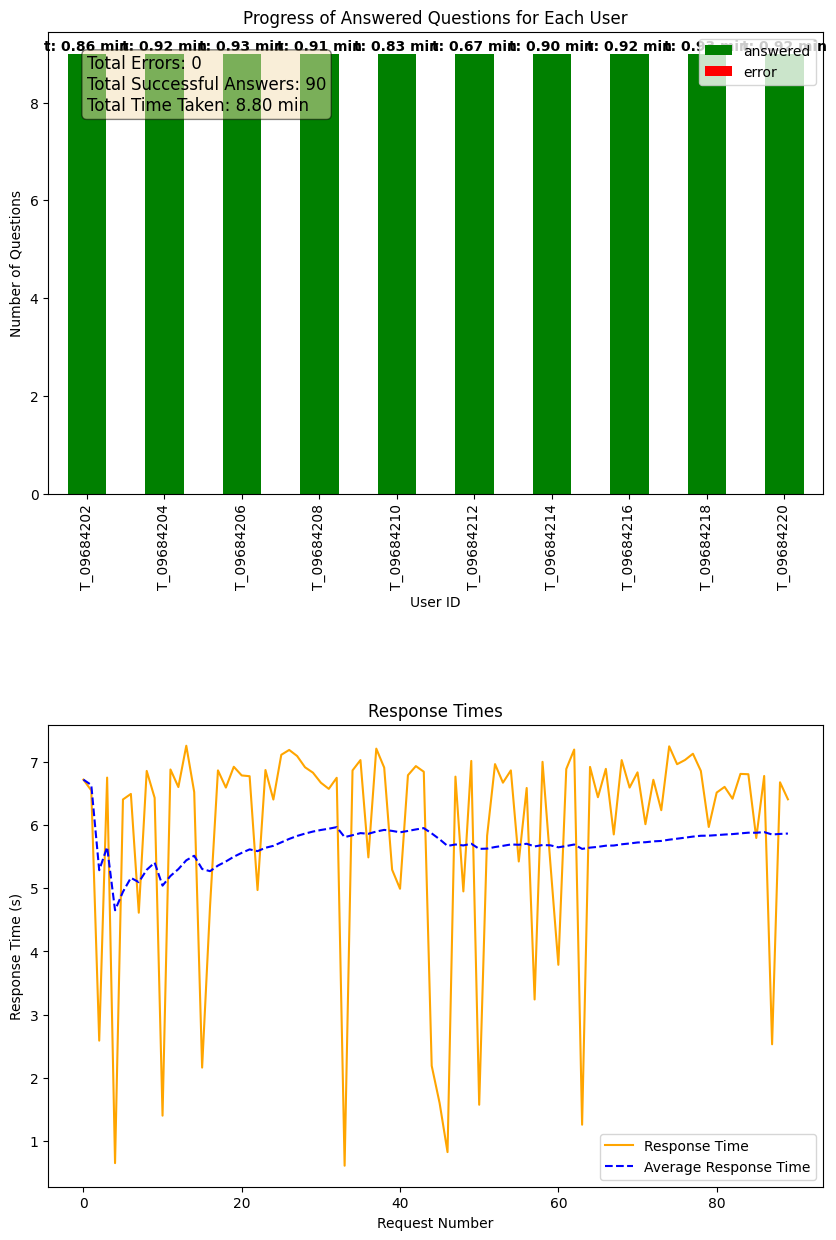

Volume testing completed with 10 users and 9 questions.

LLM Analysis and Recommendations:

 What is good about the results?
    The results show that the LLM has a high level of accuracy, with 100% successful answers and no errors. This suggests that the model is well-trained and able to provide accurate responses to the questions.
    
    What problems exist?
    There are no problems identified in the results, as the model performed perfectly. However, it's worth noting that the number of users and questions is relatively small, so it's possible that the model may not be able to handle a larger volume of traffic.
    
    How to improve performance if there are any issues?
    To improve performance, the following steps could be taken:
    - Increase the number of users and questions to test the model's ability to handle a larger volume of traffic.
    - Monitor the model's performance over time to identify any potential issues or degradation in performance.
    - Consider implemen

In [3]:
import os
import tempfile
import pandas as pd
import random
import boto3
from langchain_community.llms import Bedrock
from langchain_aws import BedrockLLM
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import time
import certifi
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display, clear_output
from threading import Lock
from datetime import datetime

# Set the AWS profile and certificate bundle
os.environ["AWS_PROFILE"] = "default"
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# Create a temporary directory for storing the uploaded files
temp_dir = tempfile.TemporaryDirectory()

# Set the model ID
model_id = "meta.llama3-8b-instruct-v1:0"

def validate_file(file_path):
    """
    Validates the uploaded file to ensure it can be read as an Excel file.
    
    Parameters:
    - file_path: str, path to the file to be validated
    
    Returns:
    - Tuple (bool, int): True if the file is valid, and the number of rows in the file
    """
    try:
        df = pd.read_excel(file_path)
        return True, df.shape[0]
    except Exception as e:
        return False, 0

def initialize_bedrock_client():
    """
    Initializes the Bedrock client.
    
    Returns:
    - bedrock_client: boto3 client, initialized Bedrock client
    """
    return boto3.client(
        service_name="bedrock-runtime",
        region_name="us-east-1"
    )

def chat(question):
    """
    Sends a question to the Bedrock LLM and returns the response.
    
    Parameters:
    - question: str, the question to be sent
    
    Returns:
    - response: dict, the response from the LLM
    """
    prompt = PromptTemplate(
        input_variables=["question"],
        template="{question}"
    )

    bedrock_chain = LLMChain(llm=llm, prompt=prompt)
    response = bedrock_chain({'question': question})
    return response

def simulate_user_questions(user_id, questions, question_ids, user_progress, user_time, response_times, avg_response_times, error_log, lock, results):
    """
    Simulates a user asking questions and updates the progress.
    
    Parameters:
    - user_id: str, ID of the user
    - questions: list, list of questions to ask
    - question_ids: list, list of question IDs corresponding to the questions
    - user_progress: dict, dictionary to store user progress
    - user_time: dict, dictionary to store time taken by the user
    - response_times: list, list to store response times for each question
    - avg_response_times: list, list to store average response times for each question
    - error_log: list, list to store error messages
    - lock: threading.Lock, lock to synchronize access to shared resources
    - results: list, list to store results for the Excel file
    """
    combined = list(zip(question_ids, questions))
    random.shuffle(combined)
    for question_id, question in combined:
        try:
            start_time = time.time()
            response = chat(question)
            answer = response["text"]
            end_time = time.time()
            time_taken = end_time - start_time
            user_time[user_id] += time_taken
            response_times.append(time_taken)
            avg_response_times.append(sum(response_times) / len(response_times))
            user_progress[user_id]["answered"] += 1
            results.append([user_id, question, answer, ""])
        except Exception as e:
            error_info = f"Error occurred for user {user_id}, question ID {question_id}, question: {question}. Error: {str(e)}"
            error_log.append(error_info)
            user_progress[user_id]["error"] += 1
            results.append([user_id, question, "", str(e)])

        with lock:
            update_plot(user_progress, user_time, response_times, avg_response_times, error_log)

def update_plot(user_progress, user_time, response_times, avg_response_times, error_log):
    """
    Updates the plot showing the progress of users and other metrics.
    
    Parameters:
    - user_progress: dict, dictionary containing progress of users
    - user_time: dict, dictionary containing time taken by users
    - response_times: list, list of response times
    - avg_response_times: list, list of average response times
    - error_log: list, list of error messages
    """
    progress_df = pd.DataFrame(user_progress).T
    fig, axes = plt.subplots(2, 1, figsize=(10, 15))

    # Adjust layout to add space between the plots
    plt.subplots_adjust(hspace=0.5)

    # Plot progress of answered questions for each user
    progress_df.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
    axes[0].set_xlabel('User ID')
    axes[0].set_ylabel('Number of Questions')
    axes[0].set_title('Progress of Answered Questions for Each User')
    axes[0].yaxis.get_major_locator().set_params(integer=True)

    # Annotate the bars with the time taken
    for p in axes[0].patches:
        width, height = p.get_width(), p.get_height()
        if height > 0:
            x, y = p.get_xy()
            user_id = progress_df.index[int(x + width / 2)]
            if user_progress[user_id]["answered"] > 0:  # Annotate only once per user
                time_text = f"{user_time[user_id] / 60:.2f} min"
                axes[0].annotate(time_text, (x + width / 2, height), 
                                 ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    # Display number of errors, successful answers, and total time taken
    total_errors = sum(user['error'] for user in user_progress.values())
    total_successes = sum(user['answered'] for user in user_progress.values())
    total_time_taken = sum(user_time.values()) / 60  # in minutes
    textstr = f'Total Errors: {total_errors}\nTotal Successful Answers: {total_successes}\nTotal Time Taken: {total_time_taken:.2f} min'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=12,
                 verticalalignment='top', bbox=props)

    # Plot response times and average response times
    axes[1].plot(response_times, label='Response Time', color='orange')
    axes[1].plot(avg_response_times, label='Average Response Time', linestyle='--', color='blue')
    axes[1].set_xlabel('Request Number')
    axes[1].set_ylabel('Response Time (s)')
    axes[1].set_title('Response Times')
    axes[1].legend()

    clear_output(wait=True)
    display(fig)
    plt.close(fig)

def analyze_results(user_count, question_count, total_successes, total_errors, total_time_taken, avg_response_times, response_times, error_log):
    """
    Analyzes the volume test results using the Bedrock LLM.
    
    Parameters:
    - user_count: int, number of users
    - question_count: int, number of questions
    - total_successes: int, total successful answers
    - total_errors: int, total errors
    - total_time_taken: float, total time taken for the volume test
    - avg_response_times: list, average response times for each request
    - response_times: list, response times for each request
    - error_log: list, list of error messages
    
    Returns:
    - analysis: str, analysis provided by the LLM
    """
    results_summary = f"""
    Volume Testing Results Summary:
    - Number of users: {user_count}
    - Number of questions: {question_count}
    - Total Successful Answers: {total_successes}
    - Total Errors: {total_errors}
    - Total Time Taken: {total_time_taken:.2f} minutes
    - Average Response Time: {sum(avg_response_times) / len(avg_response_times):.2f} seconds
    - Maximum Response Time: {max(response_times):.2f} seconds
    - Minimum Response Time: {min(response_times):.2f} seconds
    
    Error Log:
    {error_log}
    """
    
    question = f"""
    We are testing a Large Language Model (LLM). Please analyze the following volume test results and provide insights on what is good, what problems exist, and how to improve performance if there are any issues.
    
    {results_summary}
    """
    
    response = chat(question)
    return response['text']

# Placeholder for user input file paths
users_file_path = "wex-users.xlsx"  # Replace with the actual path
questions_file_path = "wex-questions.xlsx"  # Replace with the actual path

# Validate the files
is_users_valid, user_count = validate_file(users_file_path)
is_questions_valid, question_count = validate_file(questions_file_path)

error_log = []
response_times = []
avg_response_times = []
results = []

if is_users_valid and is_questions_valid:
    users = pd.read_excel(users_file_path)
    questions_df = pd.read_excel(questions_file_path)

    if 'Question' not in questions_df.columns or 'question-id' not in questions_df.columns:
        print("Error: The 'question-id' and/or 'Question' column is not found in the questions file.")
        print(f"Available columns are: {questions_df.columns.tolist()}")
    elif 'user-id' not in users.columns:
        print("Error: The 'user-id' column is not found in the users file.")
        print(f"Available columns are: {users.columns.tolist()}")
    else:
        questions = questions_df["Question"].tolist()
        question_ids = questions_df["question-id"].tolist()
        user_ids = users["user-id"].tolist()

        print(f"Number of user records: {user_count}")
        print(f"Number of questions: {question_count}")

        user_progress = {user_id: {"answered": 0, "error": 0} for user_id in user_ids}
        user_time = {user_id: 0 for user_id in user_ids}
        lock = Lock()

        bedrock_client = initialize_bedrock_client()

        llm = BedrockLLM(
            model_id=model_id,
            client=bedrock_client,
            model_kwargs={"max_gen_len": 512, "temperature": 0.5}
        )

        with ThreadPoolExecutor(max_workers=len(user_ids)) as executor:
            futures = []
            for user_id in user_ids:
                futures.append(executor.submit(simulate_user_questions, user_id, questions, question_ids, user_progress, user_time, response_times, avg_response_times, error_log, lock, results))
                time.sleep(5)

            for future in as_completed(futures):
                future.result()

        print(f"Volume testing completed with {user_count} users and {question_count} questions.")
        if error_log:
            print("Errors occurred during volume testing. Here are the details:")
            for error in error_log:
                print(error)

        # Analyze the results using the LLM
        total_successes = sum(user['answered'] for user in user_progress.values())
        total_errors = sum(user['error'] for user in user_progress.values())
        total_time_taken = sum(user_time.values()) / 60  # in minutes
        analysis = analyze_results(len(user_ids), len(questions), total_successes, total_errors, total_time_taken, avg_response_times, response_times, error_log)
        print("\nLLM Analysis and Recommendations:\n")
        print(analysis)

        # Save results to an Excel file
        results_df = pd.DataFrame(results, columns=['user-id', 'question', 'answer', 'error'])
        timestamp = datetime.now().strftime('%Y%m%d-%H%M')
        results_df.to_excel(f'volume-test-run-{timestamp}.xlsx', index=False)
        print(f"Results saved to volume-test-run-{timestamp}.xlsx")
else:
    print("One or both of the uploaded files are not valid Excel files.")


